In [2]:
%matplotlib notebook
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.misc import derivative
import datetime
import time

import pandas as pd


!pip install -q -U keras-tuner

import keras_tuner
import keras.backend
import keras.callbacks
from keras_tuner.engine.hyperparameters import HyperParameters


#machine learning:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve


import tensorflow as tf
from tensorflow import keras



#smoothing functions:
from scipy.signal import butter,filtfilt
import scipy.signal
from astropy.convolution import convolve, Box1DKernel

## Load 2004 and 2005 Data:

In [3]:
#Joe Stroud#
import pandas as pd

#Importing 2004 Cassini data with labels
df = pd.read_csv('2004_FGM_KSM_1M.TAB', delimiter = '\\s+', names = ['Time', 'Bx', 'By', 'Bz', 'BTotal', 'X', 'Y', 'Z', 'Local Hour', 'NPTS'])

#Importing 2005 Cassini data with labels
df05 = pd.read_csv('2005_FGM_KSM_1M.TAB', delimiter = '\\s+', names = ['Time', 'Bx', 'By', 'Bz', 'BTotal', 'X', 'Y', 'Z', 'Local Hour', 'NPTS'])

In [3]:
df, df05

(                       Time     Bx     By     Bz  BTotal        X        Y  \
 0       2004-05-11T00:00:30  0.061  0.142 -0.041   0.161  172.297 -404.888   
 1       2004-05-11T00:01:30  0.065  0.149 -0.039   0.169  172.295 -404.884   
 2       2004-05-11T00:02:30  0.072  0.137 -0.040   0.161  172.293 -404.880   
 3       2004-05-11T00:03:30  0.078  0.138 -0.036   0.163  172.291 -404.876   
 4       2004-05-11T00:04:30  0.071  0.143 -0.034   0.164  172.288 -404.872   
 ...                     ...    ...    ...    ...     ...      ...      ...   
 312254  2004-12-31T23:55:30 -0.111 -0.390 -0.191   0.449   19.435  -56.256   
 312255  2004-12-31T23:56:30 -0.116 -0.391 -0.204   0.457   19.436  -56.255   
 312256  2004-12-31T23:57:30 -0.138 -0.379 -0.209   0.455   19.437  -56.255   
 312257  2004-12-31T23:58:30 -0.134 -0.376 -0.200   0.447   19.438  -56.254   
 312258  2004-12-31T23:59:30 -0.136 -0.374 -0.205   0.448   19.439  -56.254   
 
              Z  Local Hour  NPTS  
 0      -57.53

## Load and Format Crossings from A. Master's Paper:

In [4]:
#Juan Jose#
#Import Adam's paper's crossings
bs_crossings = pd.read_csv('Crossings_from_Adam.csv',delimiter = ',', usecols = [1,5,6,7,8,9])

bs_crossings
#Add Time column
bs_crossings_Time = np.ones(len(bs_crossings))
bs_crossings.insert(1,"Time",bs_crossings_Time, True)

#Add Type of Crossing
bs_crossings_Type = np.ones(len(bs_crossings))
bs_crossings_Type[1::2] = -1
bs_crossings.insert(1,"Type",bs_crossings_Type, True)
bs_crossings

,Year,Type,Time,Day of Year,Time (UT),X,Y,Z
0,2004,1.0,1.0,179,946,22.4,-43.5,-4.4
1,2004,-1.0,1.0,179,1028,22.3,-43.2,-4.3
2,2004,1.0,1.0,179,1804,21.1,-40.2,-3.8
3,2004,-1.0,1.0,179,2000,20.8,-39.4,-3.7
4,2004,1.0,1.0,180,18,20.1,-37.6,-3.4
...,...,...,...,...,...,...,...,...
201,2005,-1.0,1.0,223,46,14.5,-37.8,-3.8
202,2005,1.0,1.0,223,314,14.7,-37.7,-3.8
203,2005,-1.0,1.0,223,630,15.0,-37.6,-3.8
204,2005,1.0,1.0,223,1815,16.0,-37.2,-3.7


In [5]:
#Juan Jose#
#CSV had something wrong in the formatting so I had to fix it
for i, data_point in bs_crossings.iterrows():

    Year = str(int(data_point["Year"]))
    DayofYear = str(int(data_point["Day of Year"]))
    UT = str(int(data_point["Time (UT)"]))
    
    #Fill DaysofYear points with missing 0s
    if len(DayofYear) == 2:
        DayofYear = "0" + DayofYear
        
    elif len(DayofYear) == 1:
        DayofYear = "00" + DayofYear
    
    #Fill UT points with missing 0s
    if len(UT) == 3:
        UT = "0" + UT
        
    elif len(UT) == 2:
        UT = "00" + UT
    
    elif len(UT) == 1:
        UT = "000" + UT
    
    #Split UT into hours and minutes
    hour = UT[0:2]    
    minute = UT[2:4]
    
    #Put the appropriate formatting together for the functions
    time = Year + "-" + DayofYear + "T" + hour + ":" + minute + ":30"
    
    #Substitute into dataframe
    bs_crossings.loc[i,"Time"] = time

In [6]:
bs_crossings

,Year,Type,Time,Day of Year,Time (UT),X,Y,Z
0,2004,1.0,2004-179T09:46:30,179,946,22.4,-43.5,-4.4
1,2004,-1.0,2004-179T10:28:30,179,1028,22.3,-43.2,-4.3
2,2004,1.0,2004-179T18:04:30,179,1804,21.1,-40.2,-3.8
3,2004,-1.0,2004-179T20:00:30,179,2000,20.8,-39.4,-3.7
4,2004,1.0,2004-180T00:18:30,180,18,20.1,-37.6,-3.4
...,...,...,...,...,...,...,...,...
201,2005,-1.0,2005-223T00:46:30,223,46,14.5,-37.8,-3.8
202,2005,1.0,2005-223T03:14:30,223,314,14.7,-37.7,-3.8
203,2005,-1.0,2005-223T06:30:30,223,630,15.0,-37.6,-3.8
204,2005,1.0,2005-223T18:15:30,223,1815,16.0,-37.2,-3.7


In [6]:
#Convert from YYYY-MM-DD format into YYYY-DDD:
def day_of_year(array):
    """Converts an array of dates in the YYYY-MM-DD format into YYYY-DDD
    Note this rewrites the input array so be careful"""
    
    for i, value in enumerate(array):
        
        #Separate components of the date
        Y = int(value[0:4])
        M = int(value[5:7])
        D = int(value[8:10])
        
        #Convert to date format
        date = datetime.date(day = D, month = M, year = Y)
        #Extract day of the year
        day_of_year = date.strftime('%j')
        
        #Replace MM-DD with the day of the year
        array[i] = value.replace(value[5:10],day_of_year)
        
    return(array)

#convert
df_times = np.array(df['Time'])
df_times = day_of_year(df_times)
time = day_of_year(np.array(df['Time']))
bs_crossings['Time']

fix = []
for time in bs_crossings['Time']:
    if time in df_times:
        fix.append(1)

#final format:
bs_crossings['Time']

0      2004-179T09:46:30
1      2004-179T10:28:30
2      2004-179T18:04:30
3      2004-179T20:00:30
4      2004-180T00:18:30
             ...        
201    2005-223T00:46:30
202    2005-223T03:14:30
203    2005-223T06:30:30
204    2005-223T18:15:30
205    2005-224T13:31:30
Name: Time, Length: 206, dtype: object

## Functions to Format Plot Time:

When plotting the time on the x-axis it is in the YYYY-MM-DD-TTTT format. It's preferable to only include MM-DD-TTTT. Also, since there are many points on the timeline (30 second intervals) we want to increase the interal spacing to allow for a clear view of the times.

In [7]:
#Juan Jose Juan Castella
#Tick pacing function
def tick_pace(x_array, pace):
    """Lets you pick every how many array indeces you want an x tick on your plot. 
    You input the array and a pace number (every how many indeces you want an xtick).
    
    It returns an array with the index positions in the original array that correspond to the x ticks
    and the array with the values at the tick positions
    
    Apply by using plt.xticks(ticks = tick_pace(your_x_array,your_pace)[0], labels = tick_pace(your_x_array,your_pace)[1])"""
    
    #Find length of array
    n = len(x_array)
    #Index array
    index = np.arange(0,n,1)
    #Pick every "pace" values of the index array
    index = index[0:n+1:pace]
    x_array_cut = x_array[0:n+1:pace]
    
    return index, x_array_cut



def remove_year(t_array):
    """Removes the year in an array of time measurements to make x-axes on plots of readings within the same year 
    more easy to display"""
    
    #Return array
    t_output = np.array([])
    
    for value in t_array:
        #Slice the year part off the string
        sliced_value = value[5:]
        #Append to our return
        t_output = np.append(t_output,sliced_value)
    return t_output

## Plot Crossings for Training:

In [8]:
#Joe Stroud#
#assigning variables for 2004 data:
time1 = np.array(df['Time'])
time = day_of_year(np.array(df['Time'])) #day of the year format
Bx = df['Bx']
By = df['By']
Bz = df['Bz']
BTotal = df['BTotal']
X = df['X']
Y = df['Y']
Z = df['Z']
Local_hour = df['Local Hour']
NPTS = df['NPTS']



#assigning variables for 2005 data:
time105 =np.array(df05['Time'])
time05 = day_of_year(np.array(df05['Time'])) #day of the year format
Bx05 = df05['Bx']
By05 = df05['By']
Bz05 = df05['Bz']
BTotal05 = df05['BTotal']
X05 = df05['X']
Y05 = df05['Y']
Z05 = df05['Z']
Local_hour05 = df05['Local Hour']
NPTS05 = df05['NPTS']

In [10]:
#1st set of crossings shown in N. Achilleos Paper
#june 27 2004 to october 25 2004:
print(list(time1).index('2004-06-30T00:02:30'))


67352


<IPython.core.display.Javascript object>


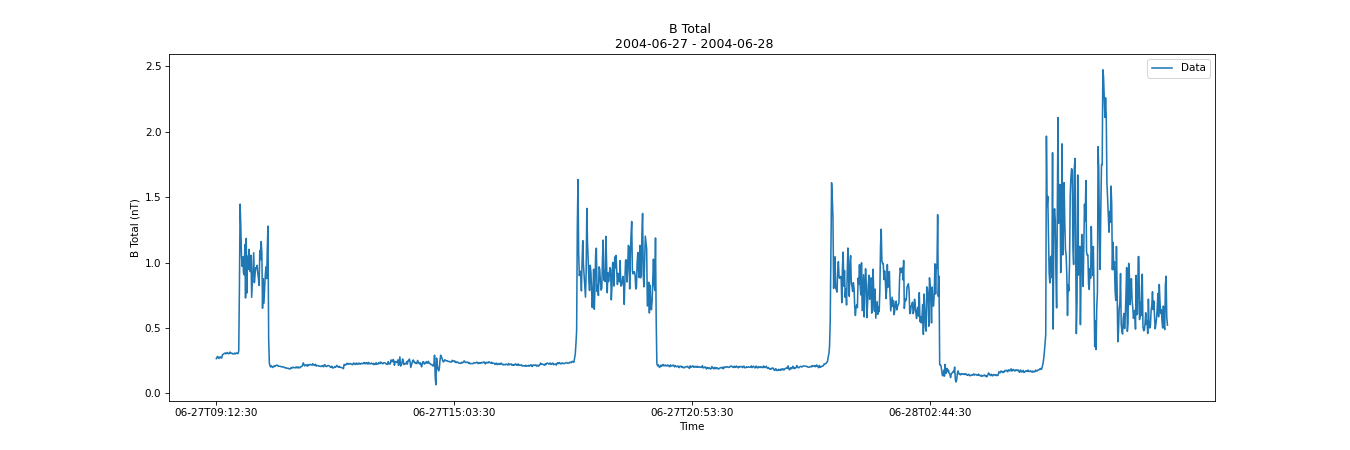

In [13]:
#1st set of crossings shown in N. Achilleos Paper:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], BTotal[63600:65000], label="Data")

plt.title('B Total \n 2004-06-27 - 2004-06-28')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[63600:65000],50*7)[0],
           labels = remove_year(tick_pace(time1[63600:65000],50*7)[1]), fontsize= 10)

plt.legend()
plt.savefig('BTotal_train.png')
plt.show()

Thee threshold is the B-value that, above which, Cassini is in the bow-shock and below which it is in the solar wind. Whether Cassini is in the BS or SW for this data range is shown in the N. Achilleos paper. Here, a threshold of 0.33 for the unormalised data was chosen.

The derivative data is not conducive to an accurate selection of thresholds. This is because the derivatives when in the bow-shock are close to the solar-wind derivatives. Therefore, the appropriate threshold is difficult to identify.

## Normalise Data:

<IPython.core.display.Javascript object>


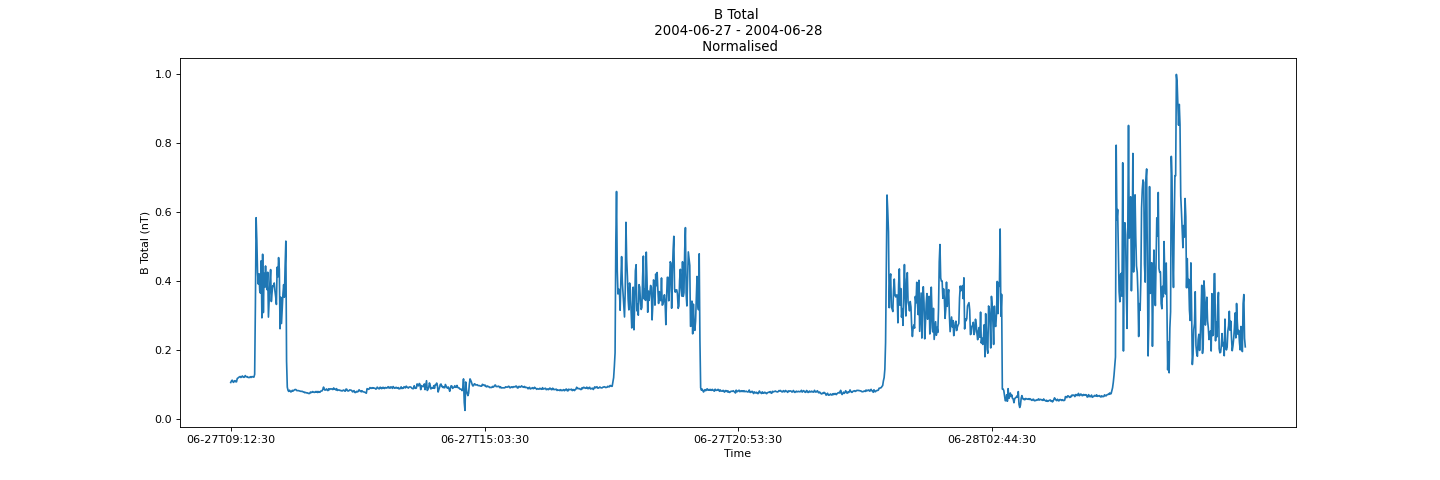

In [9]:
def norm(data):
    '''Normalised data
     Input: data
     Output: normalised data
     '''
    return data/np.amax(data) #divide by max value

#plot the normalised data:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], norm(BTotal[63600:65000]))
plt.title('B Total \n 2004-06-27 - 2004-06-28 \n Normalised')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[63600:65000],50*7)[0],
           labels = remove_year(tick_pace(time1[63600:65000],50*7)[1]), fontsize= 10)

plt.savefig('BTotal_train_norm.png')
plt.show()

## Label-Obtaining Function:

In [10]:
#labels via constant threshold method:
def label(time):
    '''Labels for the NN (the values, for the data, the NN has to get to)
    Inputs: time (the timeframe of labels wanted)
    Outputs: labels (either 0 or 1) at different points in orbit
    '''
    
    labfix = []
    counter = 1

    for i in time:       
            
        if (-1)**counter == -1:
            labfix.append(0)
        elif (-1)**counter == 1:
            labfix.append(1)
        
        for k in bs_crossings['Time']:
            if k == i:
                counter += 1
            
    return labfix

<IPython.core.display.Javascript object>


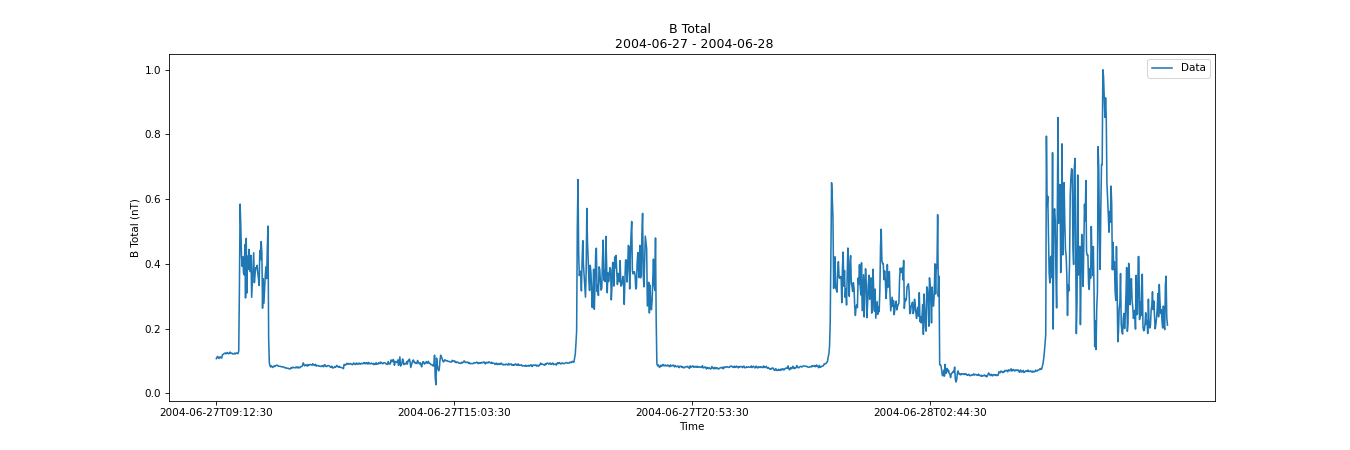

<IPython.core.display.Javascript object>


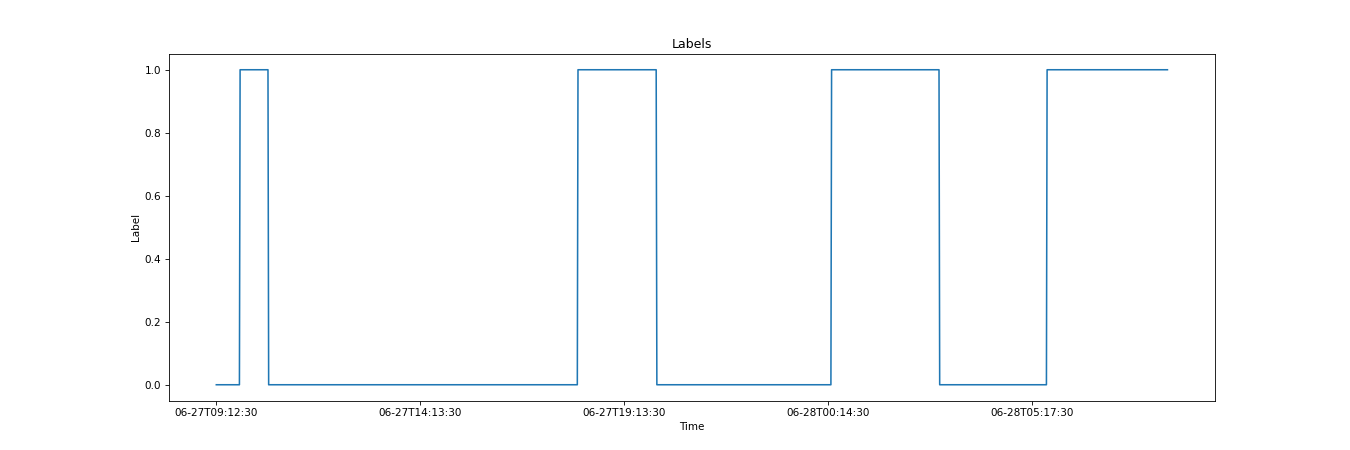

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], norm(BTotal[63600:65000]), label="Data")
plt.title('B Total \n 2004-06-27 - 2004-06-28')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')
plt.legend()

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[63600:65000],50*7)[0],
           labels = tick_pace(time1[63600:65000],50*7)[1], fontsize= 10)

plt.show()


#plot label:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], label(time[63600:65000]))
plt.title('Labels')
plt.xlabel('Time')
plt.ylabel('Label')

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[63600:65000],50*6)[0],
           labels = remove_year(tick_pace(time1[63600:65000],50*6)[1]), fontsize= 10)



plt.savefig('BTotal_train_labl.png')

plt.show()

## Neural Network:

In [11]:
X = pd.Series(norm(BTotal[63600:65000])) #data
y =  pd.Series(label(time[63600:65000])) #labels


#obtain test and training data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)

In [12]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32, input_shape=(None,1), activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 32)          64        
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           3

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                           min_delta = 0.001,
                                           patience = 6,
                                           mode = 'max',
                                           restore_best_weights = True)

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    batch_size = 32,
                    epochs=50,
                    callbacks = callback,
                    validation_data = (X_test,y_test))

Epoch 1/50
31/31 [==============================] - 2s 13ms/step - loss: 0.6712 - accuracy: 0.7837 - val_loss: 0.6398 - val_accuracy: 0.8381
Epoch 2/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.8735 - val_loss: 0.5240 - val_accuracy: 0.9524
Epoch 3/50
31/31 [==============================] - 0s 3ms/step - loss: 0.4473 - accuracy: 0.9378 - val_loss: 0.3098 - val_accuracy: 0.9905
Epoch 4/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2491 - accuracy: 0.9816 - val_loss: 0.1422 - val_accuracy: 0.9952
Epoch 5/50
31/31 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9786 - val_loss: 0.0761 - val_accuracy: 0.9952
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.9837 - val_loss: 0.0526 - val_accuracy: 0.9952
Epoch 7/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0847 - accuracy: 0.9878 - val_loss: 0.0443 - val_accuracy: 0.9952
Epoch 8/50
31/31 [=

## Loss and Accuracy Graphs Over The Epochs:

<IPython.core.display.Javascript object>


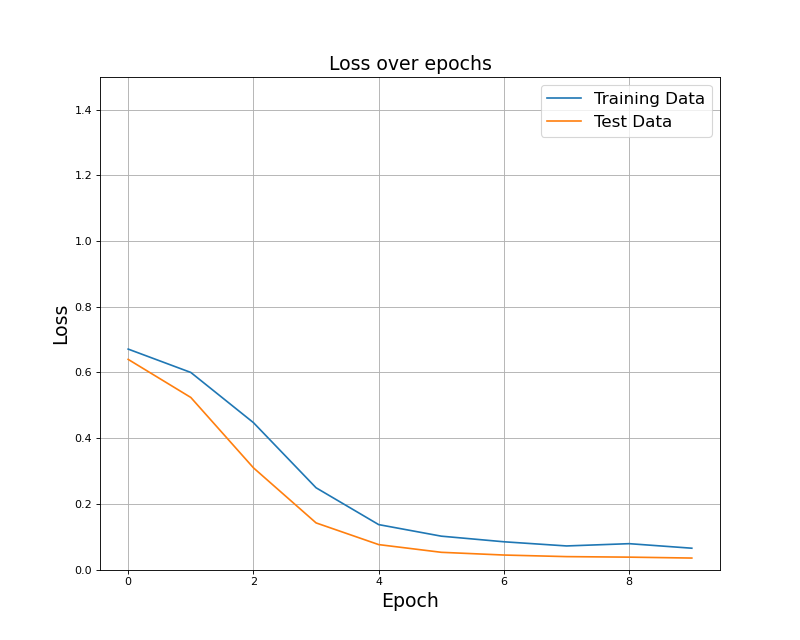

<IPython.core.display.Javascript object>


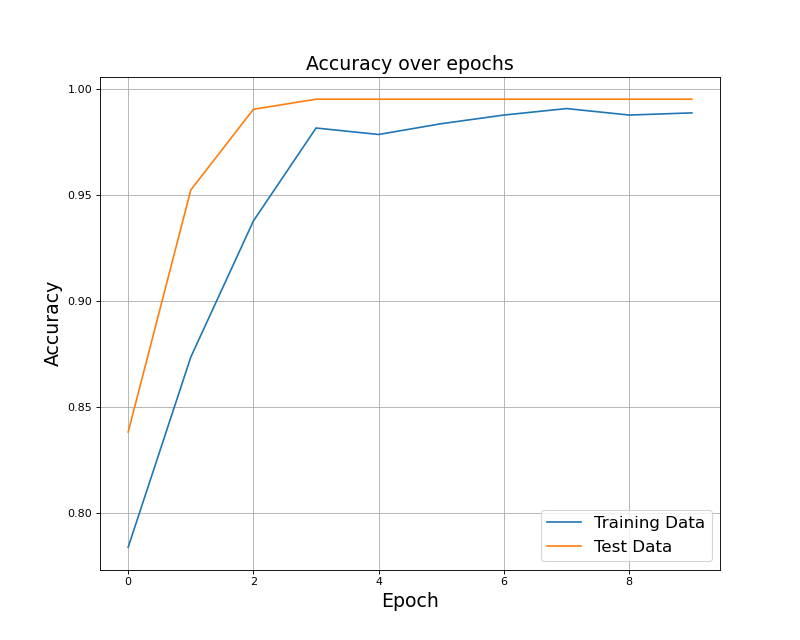

In [26]:
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'], label = "Training Data") #training loss
plt.plot(history.history['val_loss'], label = "Test Data") #test loss
plt.xlabel("Epoch", size =17)
plt.grid(True, which="both")
plt.title("Loss over epochs", size =17)
plt.ylim(0,1.5)
plt.ylabel("Loss", size =17)
plt.legend(prop={'size': 15})
plt.savefig('Loss.png')
plt.show()


plt.figure(figsize = (10,8))
plt.plot(history.history['accuracy'], label = "Training Data") #training loss
plt.plot(history.history['val_accuracy'], label = "Test Data") #test loss
plt.legend(prop={'size': 15})
plt.grid(True, which="both")
plt.title("Accuracy over epochs", size =17)
plt.xlabel("Epoch", size =17)
plt.ylabel("Accuracy", size =17)
plt.savefig('Acc.png')
plt.show()

## Test With Unseen Data:

### Smooth Data for Easy NN Input

We smooth the data before inputting testing because the it improves the accuracy.

In [15]:
def smooth(y, box_pts):
    '''Smoothed data
    Inputs: y (data), box_pts
    Output: smoothed data
    '''
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


<IPython.core.display.Javascript object>


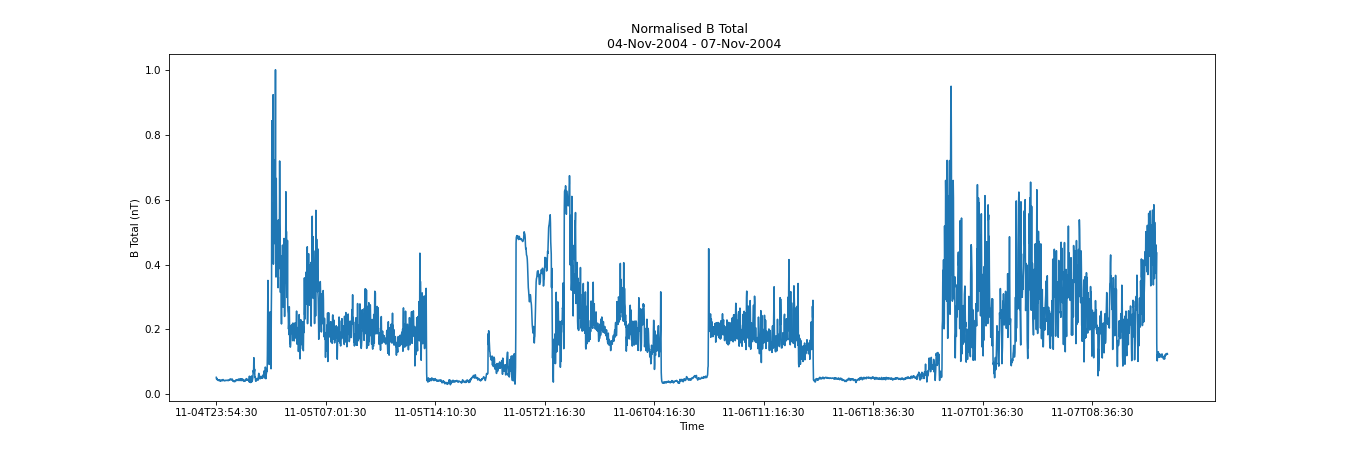

<IPython.core.display.Javascript object>


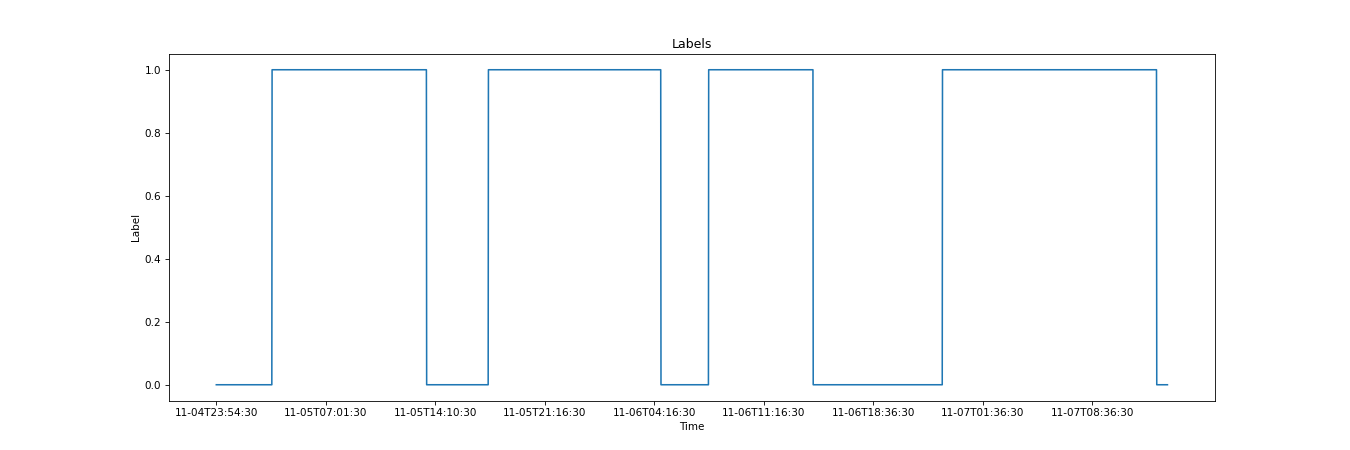

In [32]:
data = BTotal[65014:65016] #all 2004 November crossings from A. Masters paper


#plot the normalised data:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], norm(BTotal[232500:236150]), label="Data")
plt.title('Normalised B Total \n 04-Nov-2004 - 07-Nov-2004')
plt.xlabel('Time')

plt.ylabel('B Total (nT)')

plt.savefig('Norm_BT_test.png')
#plt.legend()

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*7)[0],
           labels = remove_year(tick_pace(time1[232500:236150],60*7)[1]), fontsize= 10)

plt.show()


#plot label:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], label(time[232500:236150]))
plt.title('Labels')
plt.xlabel('Time')
plt.ylabel('Label')

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*7)[0],
           labels = remove_year(tick_pace(time1[232500:236150],60*7)[1]), fontsize= 10)

plt.savefig('Norm_BT_test_lbls.png')
plt.show()

### Smooth Data for Easy NN Input

We smooth the data before inputting testing because the it improves the accuracy. We smooth the data before inputting into the NN for prediction because the it improves the accuracy. However, we train the NN with noisy data because it improves testing accuracy due to increase in data types. 

In [16]:
from astropy.convolution import convolve, Box1DKernel

def smooth(y, box_pts):
    '''Smoothed data
    Inputs: y (data), box_pts
    Output: smoothed data
    '''
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

<IPython.core.display.Javascript object>


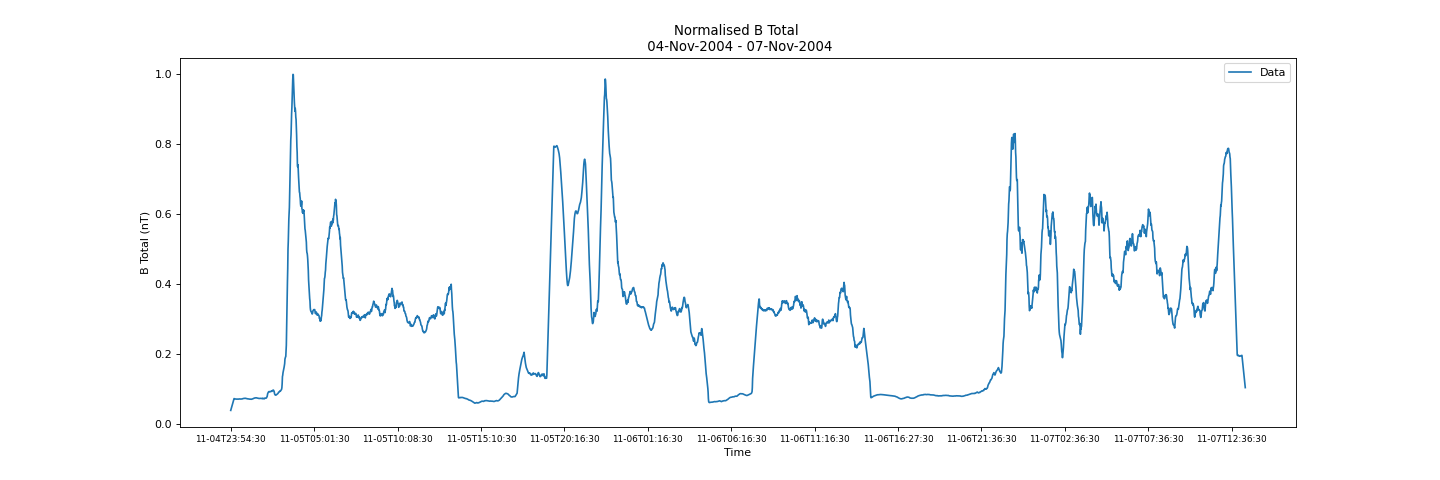

In [17]:
smoothed_signal = smooth(BTotal[232500:236150],25)

#plot the normalised and smooth data:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], norm(smoothed_signal), label="Data")
plt.title('Normalised B Total \n 04-Nov-2004 - 07-Nov-2004')
plt.xlabel('Time')

plt.ylabel('B Total (nT)')
plt.legend()

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*5)[0],
           labels = remove_year(tick_pace(time1[232500:236150],60*5)[1]), fontsize= 8)

plt.show()


### Predict Crossings of Above Data and Plot an ROC curve to visualise accuracy of NN:

There are 818 number of thresholds (i.e number of points) used to plot the ROC-curve.


<IPython.core.display.Javascript object>


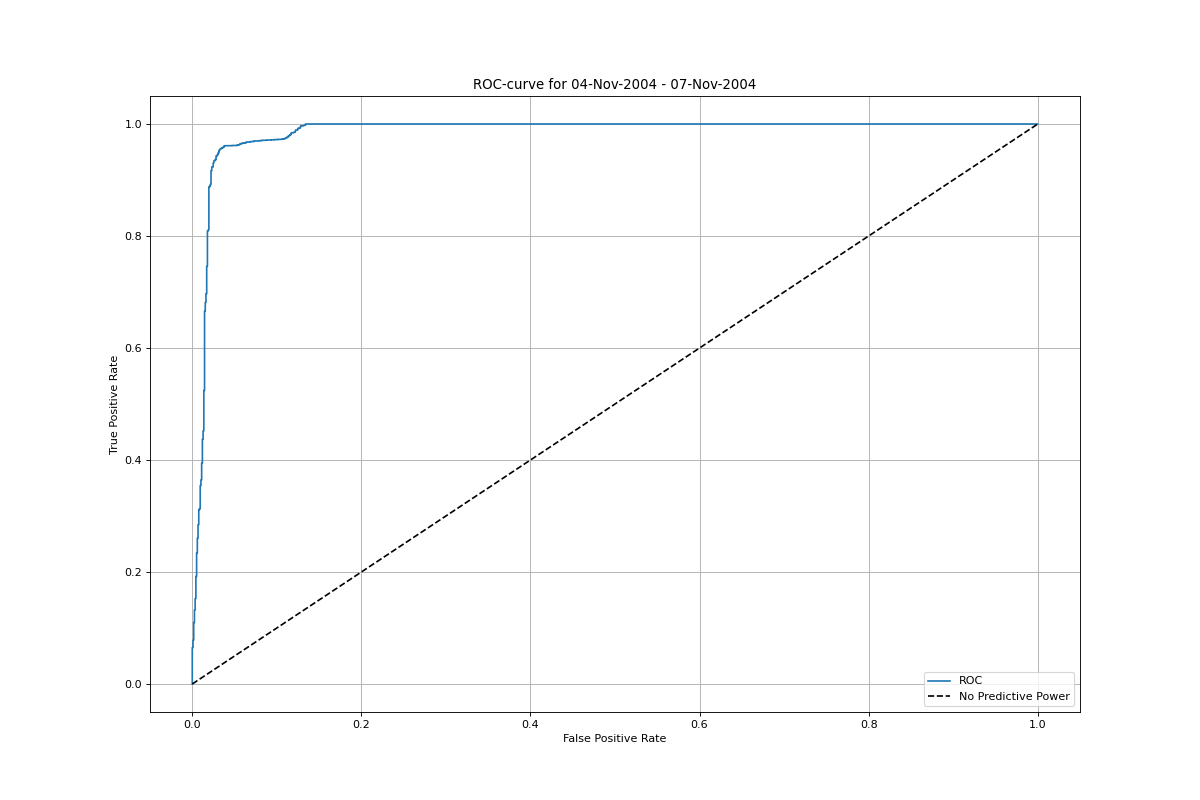

The area under the ROC-curve is = 0.98432520170676


In [18]:
X2 = np.ndarray.flatten(np.array(norm(smoothed_signal))) #data
y2 = np.ndarray.flatten(np.array(label(time[232500:236150]))) #labels

prediction = np.ndarray.flatten(model.predict(X2)) #the test prediction required to assess performance
fpr, tpr, threshold = roc_curve(y2, prediction) #labels and prediction is required to calculate TPR and FPR
print("There are", len(threshold), "number of thresholds (i.e number of points) used to plot the ROC-curve.")


plt.figure(figsize=(15,10))
plt.plot(fpr,tpr, label='ROC')
#plt.plot([0,0],[0,1], color='green', label='Perfect Predictive Power') #plot for perfect NN comparison
#plt.plot([0,1],[1,1], color='green')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.legend()
plt.grid(True, which="both")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-curve for 04-Nov-2004 - 07-Nov-2004")
plt.show()

#auc:
roc_auc = roc_auc_score(y2, prediction) #requires labels and predictions (which are probabilities)
print("The area under the ROC-curve is =", roc_auc) 

### Compare predictions from NN with labels:

<IPython.core.display.Javascript object>


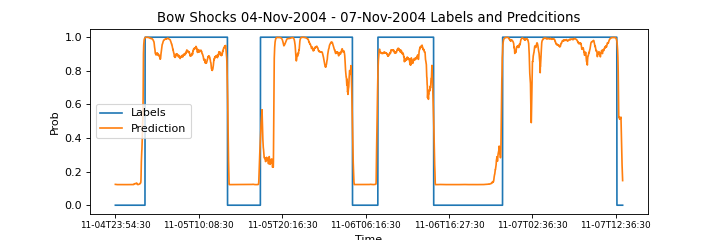

In [28]:
#prediction vs label:

plt.figure(figsize=(9, 3))
plt.plot(time[232500:236150], y2, label="Labels")
plt.plot(time[232500:236150], prediction, label="Prediction") #prediction raw
plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 Labels and Predcitions')
plt.xlabel('Time')
plt.ylabel('Prob')
plt.legend()

#space out x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*10)[0],
           labels = remove_year(tick_pace(time1[232500:236150],60*10)[1]), fontsize= 8)

plt.savefig('predvslabl.png')
plt.show()

The above prediction plot is a probability distribution where each point decribes the probability that correspoding B-Total value is closer to 0 (Solar Wind) or 1 (Bow-Shock). This is why even though while in the BS, the prediction is at 1 because, in the bow-shock, B-Total is not constant and very noisy. 

However, this issue is trivial since we are only concerned with identifying the crossings. Thus we have to smooth the predictions and round to the nearest integer to match the labels. Then calculate the gradient which will leave only the crossings:

<IPython.core.display.Javascript object>


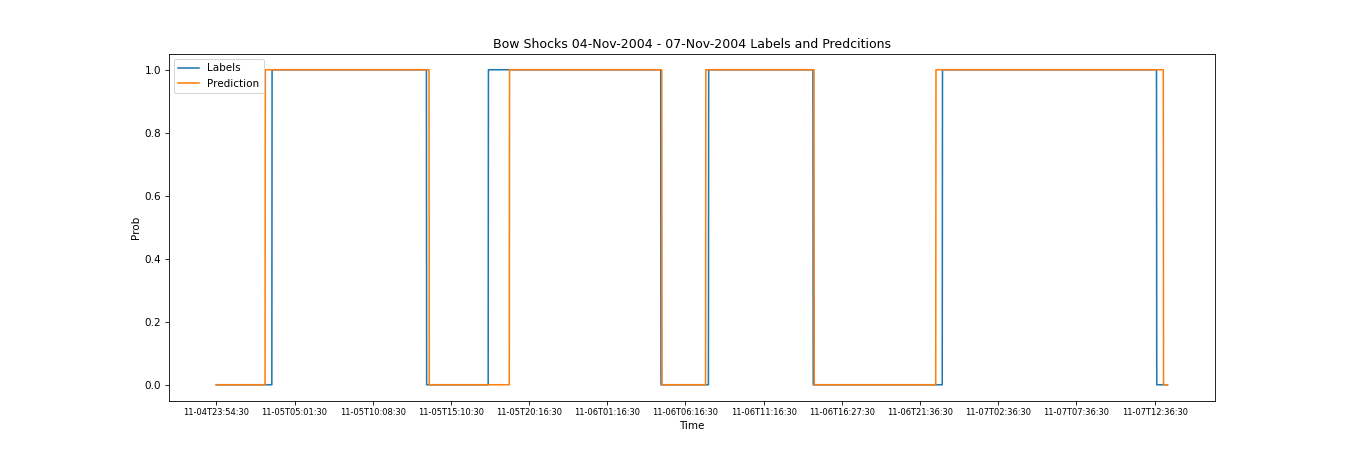

In [37]:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], y2, label="Labels")
plt.plot(time[232500:236150], np.rint(smooth(np.ndarray.flatten(prediction),50)), label="Prediction") #smooth data and round
plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 Labels and Predcitions')
plt.xlabel('Time')
plt.ylabel('Prob')
plt.legend()

#soace out x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*5)[0],
           labels = remove_year(tick_pace(time1[232500:236150],60*5)[1]), fontsize= 8)

plt.show()

As you can see, it is obvious that the virtical lines on the graph above are the positions of the crossings and predicted crossings.

## Functions to Obtain Crossings for Any Data Once NN is Trained:

In [29]:
#Savitzky–Golay filter *smoothing function*

def SG_filter(data, win, poly):
    return scipy.signal.savgol_filter(np.ndarray.flatten(data), win, poly) # window size 31, polynomial order 3

In [30]:
def pred_cross(ind_i, ind_f,bt, box_pts, win, poly):
    '''Predicted Bow-Shock Crossings

    Inputs: beg (beggining time of dataset), end (end time of dataset),
    bt (2004 or 2005 B-total?), box_pts (smoothing-level of data *box function*), 
    win (smoothing level of prediction *Savitzky–Golayfilter*), 
    poly (polynomial order of Savitzky–Golay filter)
  
    Output: pred_int_grad (an arrray of 0s and 0.5s where the 0.5s are 
    the points of predicted bow-shock crossings)'''
    
    
    b = bt[ind_i:ind_f] #B-total dataset
  
    #smooth data:
    box = np.ones(box_pts)/box_pts
    smoothed_data = np.convolve(b, box, mode='same')

    #normalise smoothed data:
    norm_smth = smoothed_data/np.amax(smoothed_data)

    #prediction:
    X = pd.Series(norm_smth) #data
    prediction = model.predict(X)

    #smooth and "straighten" predictions to give rectangular form:
    pred_smth = SG_filter(prediction,win, poly)
    straight = np.rint(prediction)


    return np.ndarray.flatten(straight) #flatten

In [31]:
def roc(ind_i, ind_f, bt, t, box_pts):
    '''ROC Curve

    Inputs: beg (beggining time of dataset), end (end time of dataset),
    bt (2004 or 2005 B-total?), t (2004 or 2005?), box_pts (smoothing-level of data *box 
    function*)
  
    Output: fpr (false positive rate), tpr(true positive rate), *ROC curve#
    is tpr vs fpr*m auc (area under ROC curve)

    '''
    
    #initial and final index or dataset:
    b = bt[ind_i:ind_f] #B-total dataset
    time = t[ind_i:ind_f] #time interval

    #smooth data:
    box = np.ones(box_pts)/box_pts
    smoothed_data = np.convolve(b, box, mode='same')
    #normalise smoothed data:
    norm_smth = smoothed_data/np.amax(smoothed_data)
    
    #prediction:
    X = np.ndarray.flatten(np.array(norm_smth)) #data
    pred= np.ndarray.flatten(model.predict(X)) #predict and flatten
    
    #labels:
    y = np.ndarray.flatten(np.array(label(t[ind_i:ind_f]))) #labels

    
    fpr, tpr, threshold = roc_curve(y, pred)
    
    #auc:
    roc_auc = roc_auc_score(y, pred)
    
    return fpr, tpr, roc_auc

## Predictions for Multiple Crossing Intervals from A. Masters Paper:

In [32]:
#selected ranges:

#04-Nov-2004 - 07-Nov-2004:
'already shown above'


#27-Oct-2004 - 04-Nov-2004:
'2004-297T20:51:30', '2005-309T22:50:30'
ind_i2 = list(time).index('2004-297T20:51:30')#initial dataset index
ind_f2 = list(time).index('2004-309T22:50:30')#final dataset index


#10-Dec-2004 - 12-Dec-2004:
'2004-345T09:00:30', '2004-347T07:59:30'
ind_i3 = list(time).index('2004-345T09:00:30')#initial dataset index
ind_f3 = list(time).index('2004-347T07:59:30')#final dataset index


#11-May-2005 - 17-May-2005:
'2005-131T07:40:30', '2005-137T14:00:30'
ind_i4 = list(time05).index('2005-131T06:40:30')#initial dataset index
ind_f4 = list(time05).index('2005-137T14:00:30')#final dataset index


#04-Jul-2005 - 08-Jul-2005:
'2005-185T17:00:30', '2005-189T22:22:30'
ind_i5 = list(time05).index('2005-185T17:00:30')#initial dataset index
ind_f5 = list(time05).index('2005-189T22:22:30')#final dataset index


#09-Aug-2005 - 11-Aug-2005:
'2005-221T17:00:30', '2005-223T07:00:30'
ind_i6 = list(time05).index('2005-221T17:00:30')#initial dataset index
ind_f6 = list(time05).index('2005-223T07:00:30')#final dataset index


<IPython.core.display.Javascript object>


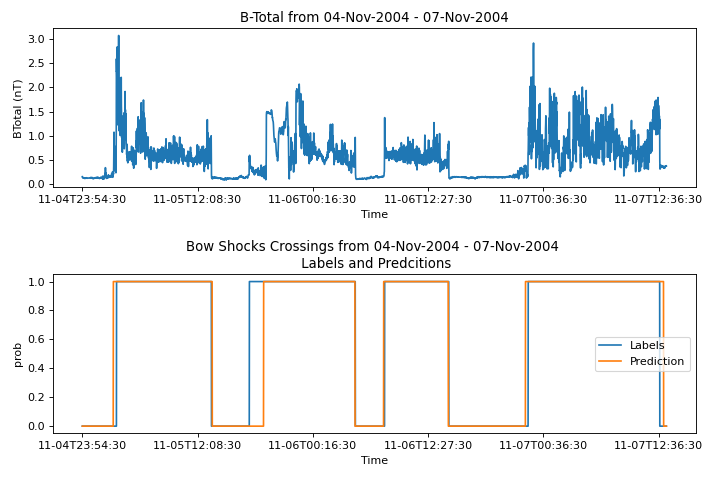

<IPython.core.display.Javascript object>


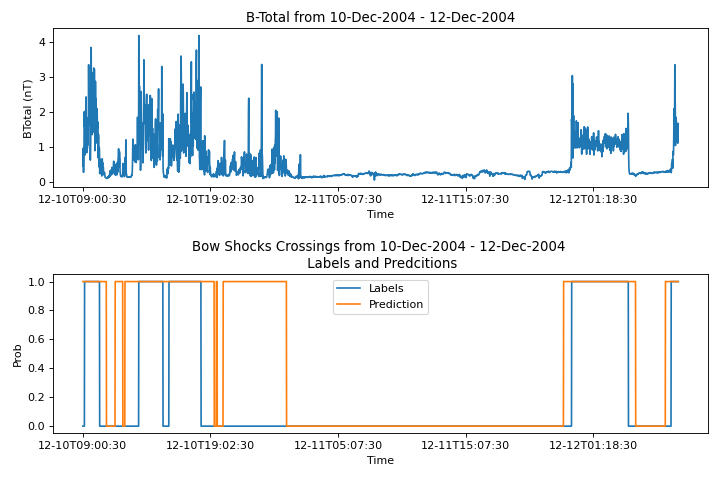

<IPython.core.display.Javascript object>


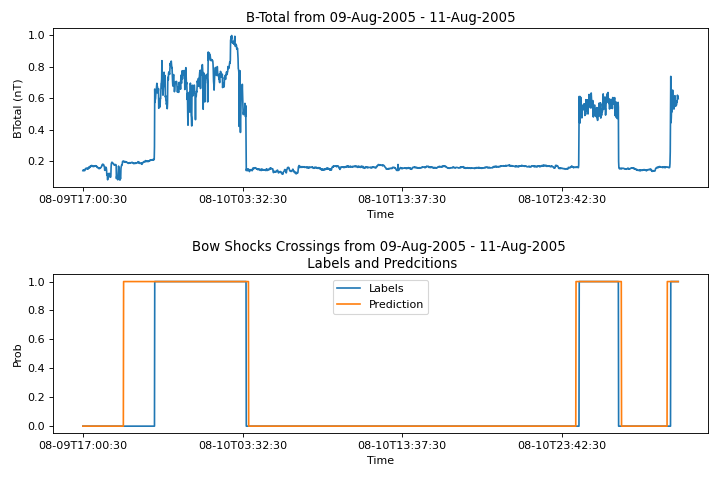

<IPython.core.display.Javascript object>


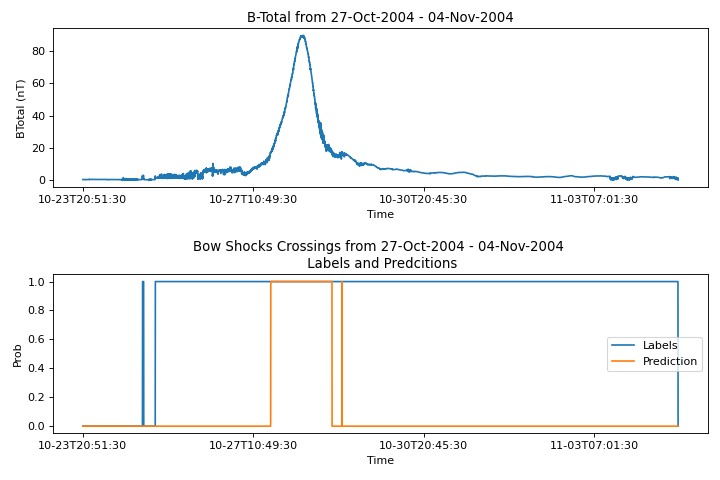

<IPython.core.display.Javascript object>


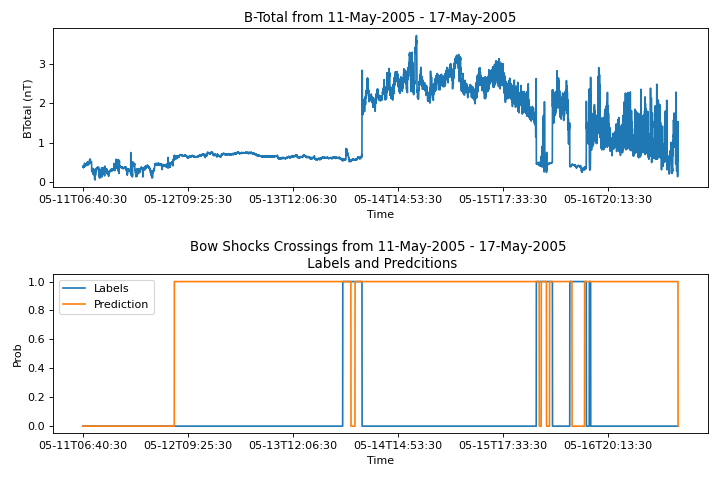

<IPython.core.display.Javascript object>


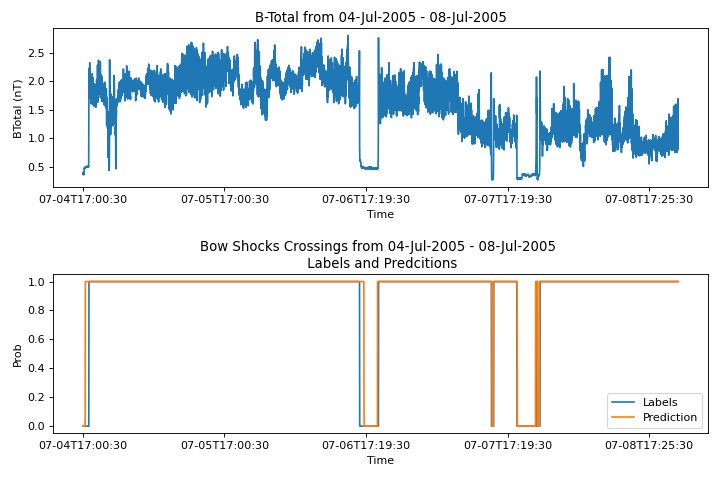

In [41]:
#04-Nov-2004 - 07-Nov-2004:
fig, ax = plt.subplots(2, figsize=(9,6))
ax[0].plot(time[232500:236150], BTotal[232500:236150])
ax[0].set_title('B-Total from 04-Nov-2004 - 07-Nov-2004')
ax[0].set(xlabel= 'Time', ylabel = 'BTotal (nT)')

ax[1].set_title('Bow Shocks Crossings from 04-Nov-2004 - 07-Nov-2004 \n Labels and Predcitions')
ax[1].plot(time[232500:236150],y2, label="Labels")
ax[1].plot(time[232500:236150], np.rint(smooth(np.ndarray.flatten(prediction),50)), label="Prediction")
ax[1].set(xlabel= 'Time', ylabel = 'prob')
ax[1].legend()

#space out x-axis time:
plt.setp(ax, xticks=tick_pace(time[232500:236150],60*12)[0],
         xticklabels = remove_year(tick_pace(time1[232500:236150],60*12)[1]))


fig.tight_layout(h_pad=2.0)
plt.savefig('test1.png')








#10-Dec-2004 - 12-Dec-2004:
fig, ax = plt.subplots(2, figsize=(9,6))
ax[0].plot(time[ind_i3:ind_f3], BTotal[ind_i3:ind_f3])
ax[0].set_title('B-Total from 10-Dec-2004 - 12-Dec-2004')
ax[0].set(xlabel= 'Time', ylabel = 'BTotal (nT)')

ax[1].set_title('Bow Shocks Crossings from 10-Dec-2004 - 12-Dec-2004 \n Labels and Predcitions')
ax[1].plot(time[ind_i3:ind_f3],label(time[ind_i3:ind_f3]), label="Labels")
ax[1].plot(time[ind_i3:ind_f3], pred_cross(ind_i3,ind_f3, BTotal,  75, 101, 2), label="Prediction")
ax[1].set(xlabel= 'Time', ylabel = 'Prob')
ax[1].legend()


#space out x-axis time:
plt.setp(ax, xticks=tick_pace(time[ind_i3:ind_f3],60*10)[0],
         xticklabels = remove_year(tick_pace(time1[ind_i3:ind_f3],60*10)[1]))


fig.tight_layout(h_pad=2.0)
plt.savefig('test2.png')




#09-Aug-2005 - 11-Aug-2005:
fig, ax = plt.subplots(2, figsize=(9,6))
ax[0].plot(time05[ind_i6:ind_f6], norm(BTotal05[ind_i6:ind_f6]))
ax[0].set_title('B-Total from 09-Aug-2005 - 11-Aug-2005')
ax[0].set(xlabel= 'Time', ylabel = 'BTotal (nT)')

ax[1].set_title('Bow Shocks Crossings from 09-Aug-2005 - 11-Aug-2005 \n Labels and Predcitions')
ax[1].plot(time05[ind_i6:ind_f6],label(time05[ind_i6:ind_f6]), label="Labels")
ax[1].plot(time05[ind_i6:ind_f6], pred_cross(ind_i6,ind_f6, BTotal05,  25, 51,1), label="Prediction")
ax[1].set(xlabel= 'Time', ylabel = 'Prob')
ax[1].legend()

#space out x-axis time:
plt.setp(ax, xticks=tick_pace(time05[ind_i6:ind_f6],60*10)[0],
         xticklabels = remove_year(tick_pace(time105[ind_i6:ind_f6],60*10)[1]))

fig.tight_layout(h_pad=2.0)
plt.savefig('test3.png')





#27-Oct-2004 - 04-Nov-2004:
fig, ax = plt.subplots(2, figsize=(9,6))
ax[0].plot(time[ind_i2:ind_f2], BTotal[ind_i2:ind_f2])
ax[0].set_title('B-Total from 27-Oct-2004 - 04-Nov-2004')
ax[0].set(xlabel= 'Time', ylabel = 'BTotal (nT)')

ax[1].set_title('Bow Shocks Crossings from 27-Oct-2004 - 04-Nov-2004 \n Labels and Predcitions')
ax[1].plot(time[ind_i2:ind_f2],label(time[ind_i2:ind_f2]), label="Labels")
ax[1].plot(time[ind_i2:ind_f2], pred_cross(ind_i2,ind_f2, BTotal,  25, 101, 2), label="Prediction")
ax[1].set(xlabel= 'Time', ylabel = 'Prob')
ax[1].legend()

#space out x-axis time:
plt.setp(ax, xticks=tick_pace(time[ind_i2:ind_f2],60*80)[0],
         xticklabels = remove_year(tick_pace(time1[ind_i2:ind_f2],60*80)[1]))

fig.tight_layout(h_pad=2.0)
plt.savefig('test4.png')




#11-May-2005 - 17-May-2005:
fig, ax = plt.subplots(2, figsize=(9,6))
ax[0].set_title('B-Total from 11-May-2005 - 17-May-2005')
ax[0].plot(time05[ind_i4:ind_f4], BTotal05[ind_i4:ind_f4])
ax[0].set(xlabel= 'Time', ylabel = 'BTotal (nT)')


ax[1].set_title('Bow Shocks Crossings from 11-May-2005 - 17-May-2005 \n Labels and Predcitions')
ax[1].plot(time05[ind_i4:ind_f4],label(time05[ind_i4:ind_f4]), label="Labels")
ax[1].plot(time05[ind_i4:ind_f4], pred_cross(ind_i4,ind_f4, BTotal05,  100, 51, 2), label="Prediction")
ax[1].set(xlabel= 'Time', ylabel = 'Prob')
ax[1].legend()

#space out x-axis time:
plt.setp(ax, xticks=tick_pace(time05[ind_i4:ind_f4],100*16)[0],
         xticklabels = remove_year(tick_pace(time105[ind_i4:ind_f4],100*16)[1]))

fig.tight_layout(h_pad=2.0)
plt.savefig('test5.png')








#04-Jul-2005 - 08-Jul-2005:
fig, ax = plt.subplots(2, figsize=(9,6))
ax[0].plot(time05[ind_i5:ind_f5], BTotal05[ind_i5:ind_f5])
ax[0].set_title('B-Total from 04-Jul-2005 - 08-Jul-2005')
ax[0].set(xlabel= 'Time', ylabel = 'BTotal (nT)')

ax[1].set_title('Bow Shocks Crossings from 04-Jul-2005 - 08-Jul-2005 \n Labels and Predcitions')
ax[1].plot(time05[ind_i5:ind_f5], label(time05[ind_i5:ind_f5]), label="Labels")
ax[1].plot(time05[ind_i5:ind_f5], pred_cross(ind_i5,ind_f5, BTotal05,  15, 25, 2), label="Prediction")
ax[1].set(xlabel= 'Time', ylabel = 'Prob')
ax[1].legend()

#space out x-axis time:
plt.setp(ax, xticks=tick_pace(time05[ind_i5:ind_f5],60*24)[0],
         xticklabels = remove_year(tick_pace(time105[ind_i5:ind_f5],60*24)[1]))

fig.tight_layout(h_pad=2.0)
plt.savefig('test6.png')





<IPython.core.display.Javascript object>


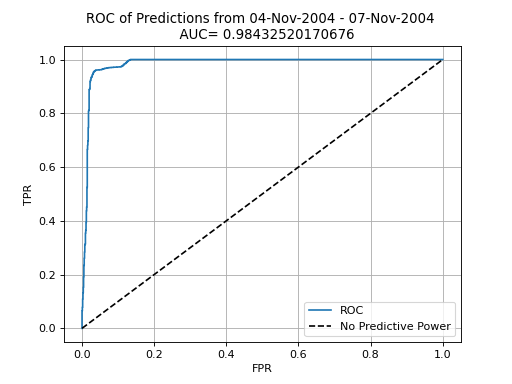

<IPython.core.display.Javascript object>


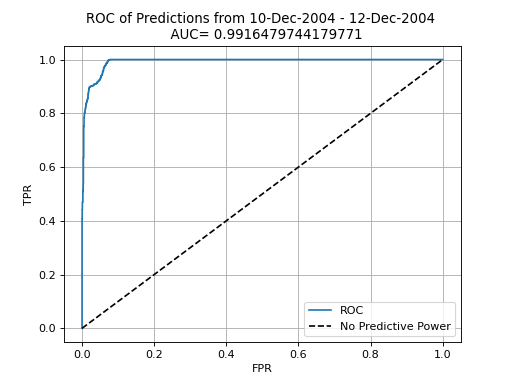

<IPython.core.display.Javascript object>


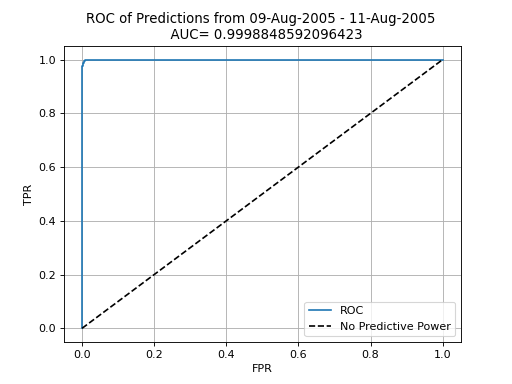

<IPython.core.display.Javascript object>


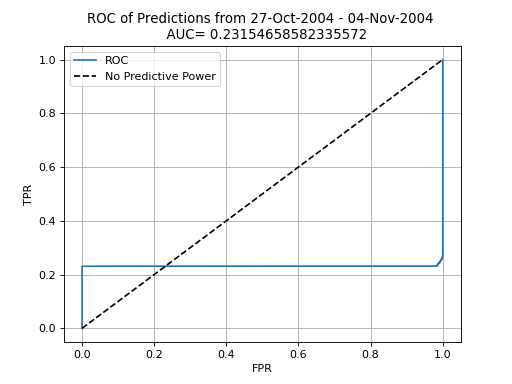

<IPython.core.display.Javascript object>


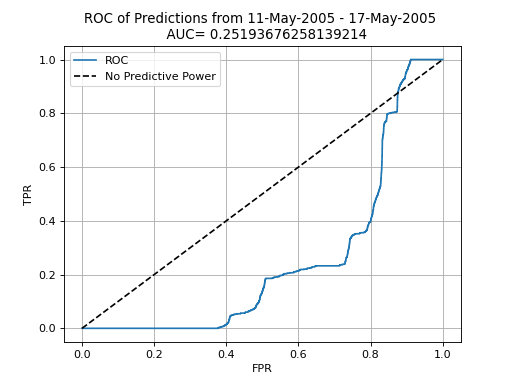

<IPython.core.display.Javascript object>


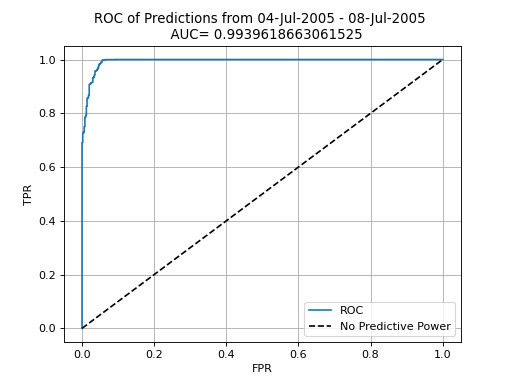

In [36]:
#04-Nov-2004 - 07-Nov-2004:
plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.xlabel( 'FPR')
plt.ylabel('TPR')
plt.title('ROC of Predictions from 04-Nov-2004 - 07-Nov-2004 \n  AUC= {}'.format(roc_auc))
plt.legend()
plt.grid(True, which="both")

plt.savefig('roc1.png')

plt.show()





#10-Dec-2004 - 12-Dec-2004:
plt.figure()
plt.plot(roc(ind_i3, ind_f3, BTotal, time, 75)[0], roc(ind_i3, ind_f3, BTotal, time, 75)[1], label='ROC')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.title('ROC of Predictions from 10-Dec-2004 - 12-Dec-2004 \n  AUC= {}'.format(roc(ind_i3, ind_f3, BTotal, time, 75)[2]))
plt.xlabel( 'FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True, which="both")


plt.savefig('roc2.png')
plt.show()


#09-Aug-2005 - 11-Aug-2005:
plt.figure()
plt.plot(roc(ind_i6, ind_f6, BTotal05, time05, 25)[0], roc(ind_i6, ind_f6, BTotal05, time05, 25)[1], label='ROC')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.title('ROC of Predictions from 09-Aug-2005 - 11-Aug-2005 \n  AUC= {}'.format(roc(ind_i6, ind_f6, BTotal05, time05, 25)[2]))
plt.xlabel( 'FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True, which="both")


plt.savefig('roc3.png')
plt.show()


#27-Oct-2004 - 04-Nov-2004:
plt.figure()
plt.plot(roc(ind_i2, ind_f2, BTotal, time, 25)[0], roc(ind_i2, ind_f2, BTotal, time, 25)[1], label='ROC')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.title('ROC of Predictions from 27-Oct-2004 - 04-Nov-2004 \n  AUC= {}'.format(roc(ind_i2, ind_f2, BTotal, time, 25)[2]))
plt.xlabel( 'FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True, which="both")

plt.savefig('roc4.png')
plt.show()



#11-May-2005 - 17-May-2005:
plt.figure()
plt.title('ROC of Predictions from 11-May-2005 - 17-May-2005 \n  AUC= {}'.format(roc(ind_i4, ind_f4, BTotal05, time05, 100)[2]))
plt.plot(roc(ind_i4, ind_f4, BTotal05, time05, 100)[0], roc(ind_i4, ind_f4, BTotal05, time05, 100)[1], label='ROC')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.xlabel( 'FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True, which="both")


plt.savefig('roc5.png')
plt.show()







#04-Jul-2005 - 08-Jul-2005:
plt.figure()
plt.plot(roc(ind_i5, ind_f5, BTotal05, time05, 15)[0], roc(ind_i5, ind_f5, BTotal05, time05, 15)[1], label='ROC')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.title('ROC of Predictions from 04-Jul-2005 - 08-Jul-2005 \n  AUC= {}'.format(roc(ind_i5, ind_f5, BTotal05, time05, 15)[2]))
plt.xlabel( 'FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True, which="both")


plt.savefig('roc6.png')
plt.show()



